<a href="https://www.kaggle.com/code/boualemhamroune/q-learning-with-td-with-taxi-v3?scriptVersionId=161788821" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import gym 
import random

In [3]:

env = gym.make("Taxi-v3").env
env.reset()

(403, {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 0], dtype=int8)})

#  Creating the Agent for the Q-Learning 

In [4]:
class QlearningAgent:
    def __init__(self,env,agent_init_info):
        self.num_actions =  env.action_space.n
        self.num_states = env.observation_space.n
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        #self.q_table=np.zeros([self.num_states, self.num_actions])
        self.q_table = np.random.rand(self.num_states, self.num_actions)
        self.env=env
    
    def  agent_start(self, observation):
        
        state = observation
        current_q = self.q_table[state,:]
        if random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()    
        else:
            action = self.argmax(current_q)
            
        self.prev_state = state
        self.prev_action = action
        return action
    
    
    
    def argmax(self, q_values):
       
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return (ties[random.randint(0,len(ties)-1 )])
    
    
    def agent_step(self, reward, observation):
        state = observation
        current_q = self.q_table[state, :]
        if random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.argmax(current_q)
         
        prev_state = self.prev_state
        prev_action = self.prev_action
     
        self.q_table[prev_state, prev_action] = self.q_table[prev_state, prev_action] + self.step_size * \
                                          (reward + self.discount * self.q_table[state, action] - self.q_table[prev_state, prev_action])
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        
        prev_state = self.prev_state
        prev_action = self.prev_action
        
        self.q_table[prev_state, prev_action] = self.q_table[prev_state, prev_action] + self.step_size * \
                                          (reward + 0 - self.q_table[prev_state, prev_action])
    

In [5]:
env = gym.make("Taxi-v3").env
env.reset()

(191, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

In [6]:
agent_info = {
              "epsilon": 0.1,
              "step_size": 0.1,
              "discount": 0.6}
agent_qlearning = QlearningAgent(env,agent_info)

In [7]:
x=0
reward_qlearning=[]
for i in range(1, 10000):
    state=env.reset()[0]

    action=agent_qlearning.agent_start(state)
    done=False
    x=0
    reward_episode=0
    while not done:
        next_state, reward, done,truncated, info = env.step(action) 
        if(done==True):
            agent_qlearning.agent_end(reward)
        else:
            action=agent_qlearning.agent_step(reward,next_state)
        x=x+1
        reward_episode+=reward
    reward_qlearning.append(reward_episode)
    if(i%1000==0):
        print(x)
    #print("episode number ",str(i))

31
45
23
30
14
17
11
1890
38


# Testing the agent 

In [8]:
def test_agent(agent, env, num_episodes=100):
    total_rewards = 0

    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        episode_reward,penalties,epochs = 0,0,0

        while not done:
            action = agent.agent_start(state)
            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            state = next_state
            if reward == -10:
                penalties += 1

            epochs += 1
        total_rewards += episode_reward

        print(f"Episode {episode + 1}, Total Reward: {episode_reward}, epochs: {epochs}, penalties: {penalties}")

    average_reward = total_rewards / num_episodes
    print(f"\nAverage Reward over {num_episodes} episodes: {average_reward}")

# Assuming 'agent' and 'env' are already defined
num_test_episodes = 10  # You can adjust this based on your preferences
test_agent(agent_qlearning, env, num_episodes=num_test_episodes)

Episode 1, Total Reward: 11, epochs: 10, penalties: 0
Episode 2, Total Reward: -9, epochs: 21, penalties: 1
Episode 3, Total Reward: -4, epochs: 16, penalties: 1
Episode 4, Total Reward: -38, epochs: 59, penalties: 0
Episode 5, Total Reward: 8, epochs: 13, penalties: 0
Episode 6, Total Reward: -2, epochs: 14, penalties: 1
Episode 7, Total Reward: 5, epochs: 16, penalties: 0
Episode 8, Total Reward: 6, epochs: 15, penalties: 0
Episode 9, Total Reward: 9, epochs: 12, penalties: 0
Episode 10, Total Reward: 12, epochs: 9, penalties: 0

Average Reward over 10 episodes: -0.2


# a test without using the trained agent 

In [9]:
def test_agent(agent, env, num_episodes=100):
    total_rewards = 0

    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        episode_reward,penalties,epochs = 0,0,0

        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            #state = next_state
            if reward == -10:
                penalties += 1

            epochs += 1
        total_rewards += episode_reward

        print(f"Episode {episode + 1}, Total Reward: {episode_reward}, epochs: {epochs}, penalties: {penalties}")

    average_reward = total_rewards / num_episodes
    print(f"\nAverage Reward over {num_episodes} episodes: {average_reward}")

# Assuming 'agent' and 'env' are already defined
num_test_episodes = 10  # You can adjust this based on your preferences
test_agent(agent_qlearning, env, num_episodes=num_test_episodes)

Episode 1, Total Reward: -3896, epochs: 992, penalties: 325
Episode 2, Total Reward: -7376, epochs: 1871, penalties: 614
Episode 3, Total Reward: -1474, epochs: 352, penalties: 127
Episode 4, Total Reward: -4608, epochs: 1218, penalties: 379
Episode 5, Total Reward: -5954, epochs: 1529, penalties: 494
Episode 6, Total Reward: -6888, epochs: 1833, penalties: 564
Episode 7, Total Reward: -4006, epochs: 1084, penalties: 327
Episode 8, Total Reward: -24163, epochs: 6103, penalties: 2009
Episode 9, Total Reward: -27530, epochs: 7013, penalties: 2282
Episode 10, Total Reward: -6203, epochs: 1616, penalties: 512

Average Reward over 10 episodes: -9209.8


# Creating the agent for the SARSA 

In [10]:
class SarsaAgent:
    def __init__(self,env,agent_init_info):
        self.num_actions =  env.action_space.n
        self.num_states = env.observation_space.n
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        #self.q_table=np.zeros([self.num_states, self.num_actions])
        self.q_table = np.random.rand(self.num_states, self.num_actions)
        self.env=env
    
    def  agent_start(self, observation):
        
        state = observation
        current_q = self.q_table[state,:]
        if random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()    
        else:
            action = self.argmax(current_q)
            
        self.prev_state = state
        self.prev_action = action
        return action
    
    
    
    def argmax(self, q_values):
       
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return (ties[random.randint(0,len(ties)-1 )])
    
    
    def agent_step(self, reward, observation):
        state = observation
        current_q = self.q_table[state, :]
        if random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.argmax(current_q)
         
        prev_state = self.prev_state
        prev_action = self.prev_action
        
        expected_term = 0
        for a in range(self.num_actions):
            expected_term += self.q_table[state, a] / self.num_actions
        self.q_table[prev_state, prev_action] += self.step_size * (reward + self.discount * expected_term - self.q_table[prev_state, prev_action])
        ### END CODE HERE ###
     
        #self.q_table[prev_state, prev_action] = self.q_table[prev_state, prev_action] + self.step_size * \
                                          #(reward + self.discount * self.q_table[state, action] - self.q_table[prev_state, prev_action])
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        
        prev_state = self.prev_state
        prev_action = self.prev_action
        
        self.q_table[prev_state, prev_action] = self.q_table[prev_state, prev_action] + self.step_size * \
                                          (reward + 0 - self.q_table[prev_state, prev_action])
    

In [11]:
agent_info = {
              "epsilon": 0.1,
              "step_size": 0.1,
              "discount": 0.6}
agent_sarsa = SarsaAgent(env,agent_info)

In [12]:
x=0
reward_sarsa=[]

for i in range(1, 10000):
    state=env.reset()[0]

    action=agent_sarsa.agent_start(state)
    done=False
    x=0
    reward_episode=0
    while not done:
        next_state, reward, done,truncated, info = env.step(action) 
        reward_episode+=reward
        if(done==True):
            agent_sarsa.agent_end(reward)
        else:
            action=agent_sarsa.agent_step(reward,next_state)
        x=x+1
    reward_sarsa.append(reward_episode)
    if(i%1000==0):
        print(x)
    #print("episode number ",str(i))
    
print("the end ")

43
84
3028
157
232
263
3182
4053
511
the end 


# test the Sarsa agent 

In [13]:
def test_agent(agent, env, num_episodes=100):
    total_rewards = 0

    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        episode_reward,penalties,epochs = 0,0,0

        while not done:
            action = agent.agent_start(state)
            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            state = next_state
            if reward == -10:
                penalties += 1

            epochs += 1
        total_rewards += episode_reward

        print(f"Episode {episode + 1}, Total Reward: {episode_reward}, epochs: {epochs}, penalties: {penalties}")

    average_reward = total_rewards / num_episodes
    print(f"\nAverage Reward over {num_episodes} episodes: {average_reward}")

# Assuming 'agent' and 'env' are already defined
num_test_episodes = 10  # You can adjust this based on your preferences
test_agent(agent_sarsa, env, num_episodes=num_test_episodes)

Episode 1, Total Reward: -4958, epochs: 4232, penalties: 83
Episode 2, Total Reward: -40111, epochs: 30925, penalties: 1023
Episode 3, Total Reward: -3345, epochs: 2700, penalties: 74
Episode 4, Total Reward: -1431, epochs: 1056, penalties: 44
Episode 5, Total Reward: -1062291, epochs: 818160, penalties: 27128
Episode 6, Total Reward: -6597, epochs: 4971, penalties: 183
Episode 7, Total Reward: -565, epochs: 487, penalties: 11
Episode 8, Total Reward: -502948, epochs: 433120, penalties: 7761
Episode 9, Total Reward: -1588, epochs: 1384, penalties: 25
Episode 10, Total Reward: -3735, epochs: 2982, penalties: 86

Average Reward over 10 episodes: -162756.9


# comparing the two methods 

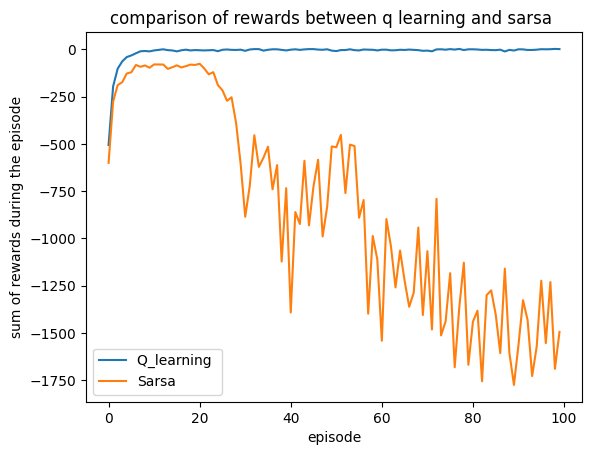

In [14]:
import matplotlib.pyplot as plt




# Function to calculate the median for each window of size window_size
def calculate_window_median(data, window_size):
    medians = []
    for i in range(0, len(data), window_size):
        window = data[i:i + window_size]
        medians.append(np.median(window))
    return medians

# Window size
window_size = 100

# Calculate medians for each array
medians_reward_qlearning = calculate_window_median(reward_qlearning, window_size)
medians_reward_sarsa = calculate_window_median(reward_sarsa, window_size)


# Plotting the arrays as lines
plt.plot(medians_reward_qlearning, label='Q_learning ')
plt.plot(medians_reward_sarsa, label='Sarsa')

# Adding labels and title
plt.xlabel('episode')
plt.ylabel('sum of rewards during the episode')
plt.title('comparison of rewards between q learning and sarsa ')

# Adding a legend
plt.legend()

# Display the plot
plt.show()
